<center><h1> Classifying Ships in Satellite Imagery using CNN </h1></center>

<img src='shipimg.jpg' width='800' height='700' />

* **Dataset** : [Classifying Ships in Satellite Imagery](https://www.kaggle.com/rhammell/ships-in-satellite-imagery?select=shipsnet)

**Content** :

- The dataset consists of image chips extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. 

- It includes `4000 80x80` RGB images labeled with either a "ship" or "no-ship" classification. 

**Data** :

- `label`: Valued 1 or 0, representing the "ship" class and "no-ship" class, respectively.


- `scene id` : The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.


- `data` : The pixel values are stored in a column in the data frame titled “data.”

`The dataset is also distributed as a JSON formatted text file shipsnet.json. The loaded object contains data, label, scene_ids, and location lists.`

* The pixel value data for each `80x80 RGB image` is stored as a list of `19200 integers` within the data list. 

* The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.models import Sequential

In [5]:
from tensorflow.keras.layers import Conv2D

In [6]:
# used for reduce data dimensionality
from tensorflow.keras.layers import MaxPooling2D

In [7]:
from tensorflow.keras.layers import Dropout

In [8]:
# number of units proportional to input
from tensorflow.keras.layers import Flatten

In [9]:
#regular dense connected layer
from tensorflow.keras.layers import Dense

In [10]:
from tensorflow.keras.layers import Activation

In [11]:
from tensorflow.keras.optimizers import Adam

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

In [14]:
from tensorflow.keras.models import load_model

In [15]:
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [16]:
dataset = pd.read_json("shipsnet.json")
dataset

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007
...,...,...,...,...
3995,"[126, 122, 124, 138, 165, 186, 195, 199, 203, ...",0,"[-122.08693255500694, 37.77781408256089]",20170815_180821_102d
3996,"[130, 134, 139, 128, 117, 126, 141, 147, 142, ...",0,"[-122.10549691828378, 37.76946626247702]",20170730_191230_0f21
3997,"[171, 135, 118, 140, 145, 144, 154, 165, 139, ...",0,"[-122.48298739296371, 37.684929808845375]",20161116_180804_0e14
3998,"[85, 90, 94, 95, 94, 92, 93, 96, 93, 94, 94, 9...",0,"[-122.29028216570079, 37.71632091139081]",20170211_181116_0e16


In [17]:
dataset['data'].shape

(4000,)

## Transform Data

**As is, these pixel values aren’t ready to be processed by a CNN. Instead, the new data is converted to a NumPy array and divided by 255 to normalize the values.**

**All 19,200 values should now be some value between 0 and 1.**

**Next the data is reshaped to 80 x 80 x 3 matrix so that it’s formatted as a picture**

In [18]:
dataset['normalized_data'] = dataset['data'].apply(lambda x : (np.array(x)/255).reshape(80,80,3)) 

In [19]:
dataset['normalized_data'].shape

(4000,)

In [20]:
dataset.head()

,data,labels,locations,scene_ids,normalized_data
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47,"[[[0.3215686274509804, 0.34901960784313724, 0...."
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e,"[[[0.2980392156862745, 0.29411764705882354, 0...."
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06,"[[[0.49019607843137253, 0.4980392156862745, 0...."
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a,"[[[0.4, 0.38823529411764707, 0.443137254901960..."
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007,"[[[0.3058823529411765, 0.2980392156862745, 0.2..."


## Split Data

In [21]:
X = dataset["normalized_data"]
y = dataset["labels"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [23]:
X_train.shape

(3000,)

In [24]:
X_train

678     [[[0.32941176470588235, 0.32941176470588235, 0...
2427    [[[0.4666666666666667, 0.47058823529411764, 0....
3574    [[[0.050980392156862744, 0.12549019607843137, ...
1119    [[[0.4470588235294118, 0.4627450980392157, 0.4...
2931    [[[0.40784313725490196, 0.4117647058823529, 0....
                              ...                        
835     [[[0.16862745098039217, 0.1843137254901961, 0....
3264    [[[0.4235294117647059, 0.43137254901960786, 0....
1653    [[[0.30196078431372547, 0.2980392156862745, 0....
2607    [[[0.43529411764705883, 0.4235294117647059, 0....
2732    [[[0.5019607843137255, 0.4980392156862745, 0.4...
Name: normalized_data, Length: 3000, dtype: object

**Unfortunately, Pandas Series aren’t accepted in TensorFlow, so the training and testing data are converted into arrays**

In [25]:
X_train = np.array([i  for i in X_train])
X_test = np.array([i  for i in X_test])

y_train = np.array([i  for i in y_train])
y_test = np.array([i  for i in y_test])

In [26]:
X_train.shape

(3000, 80, 80, 3)

In [27]:
X_train.shape[1:]

(80, 80, 3)

## Train CNN model

**The CNN is initialized as a sequential model, which ensures each layer receives one input and one output.**

In [28]:
model = Sequential()

**Conv2D: convulutional layer. In the first layer the input is shaped (80, 80, 3): a 3D-object of 80x80x3, or a matrix 80x80 for each channel of information (R, G, B)**

 The first layer is a convolution layer which uses a “ReLu” activation function and expects an input tensor of 80 x 80 x 3, the exact dimensions of the training images. The 32 represents the dimensionality of the output of the layer and the (3, 3) represents the size of the convolution window, 3px x 3px in this case.

The next layer added is for max pooling, which takes a pool size of 2 x 2.

In [29]:
# 1st convulsion layer
model.add(
           Conv2D(
                   filters     = 32                ,
                   kernel_size = (3,3)             ,
                   input_shape = X_train.shape[1:] ,
                   activation  = 'relu'            ,
                  )
           )


model.add(
           MaxPooling2D(pool_size=(2,2))
         )

In [30]:
# hidden layer 1

model.add(
           Conv2D(
                   filters     = 64                ,
                   kernel_size = (3,3)             ,
                   activation  = 'relu'            ,
                  )
           )


model.add(
           MaxPooling2D(pool_size=(2,2))
         )

model.add(
           Dropout(0.25)
         )

In [31]:
# hidden layer 2

model.add(
           Conv2D(
                   filters     = 64                ,
                   kernel_size = (3,3)             ,
                   activation  = 'relu'            ,
                  )
           )

In [32]:
# hidden layer 3

model.add(
           Conv2D(
                   filters     = 64                ,
                   kernel_size = (3,3)             ,
                   activation  = 'relu'            ,
                  )
           )

In [33]:
model.add(
           MaxPooling2D(pool_size=(2,2))
         )

model.add(
           Dropout(0.25)
         )

In [34]:
# Flattens the input into a 1D tensor
# this line simply flattens the tensor into a 1 dimension, which will make processing easier.

model.add(
           Flatten()
         )

In [35]:
# Makes the input more readable for classification

model.add(
            Dense(
                   64, 
                   activation='relu'
                 )
         )

In [36]:
# again called dropout for some extra regularization

model.add(
           Dropout(0.5)
         )

In [37]:
# add on that final dense layer 
# so that our output is equal to the number of classes 

model.add(
           Dense(1)
         )

In [38]:
# Final activation function
# Finally an activation layer is added which tells the whether or not to fire the neuron.

model.add(Activation('sigmoid'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3

In [40]:
# Compile the model

'''
Use binary_crossentropy because there are only 2 classes present
'''

model.compile(
               loss      = 'binary_crossentropy' , 
               optimizer = 'rmsprop'             , 
               metrics   = ['accuracy']
             )

The epochs argument essentially tells the model how many iterations to go through.

There’s a diminishing margin of return for setting epochs. A higher number will generally return a better accuracy, but each additional gain in accuracy will decrease until it approaches the maximum amount of accuracy the dataset can produce. 

Additionally, more epochs will take longer to run.

In [41]:
model_history = model.fit(
                           X_train                           , 
                           y_train                           ,
                           #batch_size      = 32              ,
                           epochs          = 10              ,
                           validation_data = (X_test, y_test),
                           #shuffle         = True
                         )

Epoch 1/10
94/94 [==============================] - 42s 375ms/step - loss: 0.4428 - accuracy: 0.8143 - val_loss: 0.2271 - val_accuracy: 0.9190
Epoch 2/10
94/94 [==============================] - 25s 261ms/step - loss: 0.2441 - accuracy: 0.8893 - val_loss: 0.1569 - val_accuracy: 0.9520
Epoch 3/10
94/94 [==============================] - 23s 246ms/step - loss: 0.1739 - accuracy: 0.9260 - val_loss: 0.1165 - val_accuracy: 0.9660
Epoch 4/10
94/94 [==============================] - 23s 247ms/step - loss: 0.1409 - accuracy: 0.9537 - val_loss: 0.2269 - val_accuracy: 0.9110
Epoch 5/10
94/94 [==============================] - 23s 246ms/step - loss: 0.1133 - accuracy: 0.9640 - val_loss: 0.0870 - val_accuracy: 0.9720
Epoch 6/10
94/94 [==============================] - 23s 247ms/step - loss: 0.0904 - accuracy: 0.9683 - val_loss: 0.0905 - val_accuracy: 0.9640
Epoch 7/10
94/94 [==============================] - 23s 249ms/step - loss: 0.0880 - accuracy: 0.9740 - val_loss: 0.0565 - val_accuracy: 0.9800

After returning the number of samples and giving the time to train the epoch, the line will also return the loss and accuracy of the model on its own training set of images as well as its loss and accuracy for the validation set.

In this case, on the 10th epoch, the model achieved `98.40% accuracy` on its own **training images** and `98.00% accuracy` on **validation images** images the model had never seen before.

In [42]:
val_loss ,val_acc = model.evaluate(X_test ,y_test)
print("Validation loss     : {:.2f}".format(val_loss) )
print("Validation accuracy : {:.2f} %".format(val_acc*100))

32/32 [==============================] - 2s 68ms/step - loss: 0.0816 - accuracy: 0.9800
Validation loss     : 0.08
Validation accuracy : 98.00 %


Text(0.5, 1.0, 'Model Accuracy')

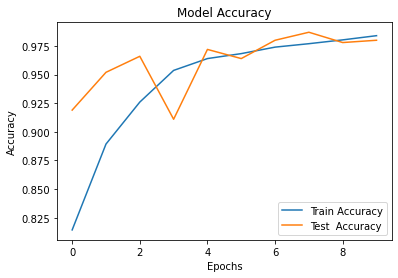

In [43]:
train_acc = model_history.history['accuracy']
val_acc   = model_history.history['val_accuracy']

plt.plot(train_acc ,label='Train Accuracy')
plt.plot(val_acc   ,label='Test  Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.title("Model Accuracy")

Text(0.5, 1.0, 'Model Loss')

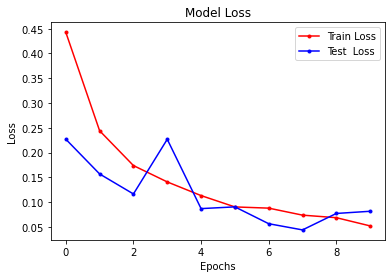

In [44]:
train_loss = model_history.history['loss']
val_loss   = model_history.history['val_loss']

plt.plot(train_loss ,color='red'  ,marker='.' ,label='Train Loss')
plt.plot(val_loss   ,color='blue' ,marker='.' ,label='Test  Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.title("Model Loss")

## Evaluation

In [45]:
y_pred = model.predict(X_test)
y_pred = (y_pred>0.5)

In [46]:
accuracy_score(y_test,y_pred)

0.98

In [47]:
confusion_matrix(y_test,y_pred)

array([[713,  19],
       [  1, 267]], dtype=int64)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       732
           1       0.93      1.00      0.96       268

    accuracy                           0.98      1000
   macro avg       0.97      0.99      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [49]:
y_prob = model.predict(X_test)

In [50]:
auc = roc_auc_score(y_test,y_prob)
auc

0.9960086860778077

In [51]:
def plot_roc(y_test ,y_prob ,model):
    
    fpr, tpr, thr = roc_curve(y_test, y_prob)
    
    plt.plot(fpr ,tpr ,'k-')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
    
    plt.grid(True)
    
    plt.title("ROC Curve : " + model)

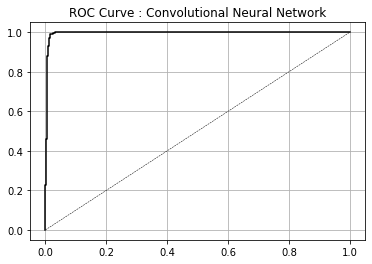

In [52]:
plot_roc(y_test, y_prob, 'Convolutional Neural Network')

## Saving Model

The save method simply takes the name of the path to save it as a H5 file.

In [ ]:
model.save("MiniProject__Sem05.h5")

# Load a model

In [ ]:
new_model = load_model("MiniProject__Sem05.h5")